In [1]:
import Pkg
Pkg.add("Plots")


Pkg.pkg"add Plots#master"

Pkg.add("PyPlot")
Pkg.add("GR")
Pkg.add("UnicodePlots")
Pkg.add("PlotlyJS");

# Simulation of FPUT Lattice w/ Planar Motion

We simulate the Fermi-Pasta-Ulam-Tsingou lattice under planar motion. The equations of motion can be found using Newton's Second law in the case of a central force model or via Euler-Langrange equations when considering a restorative force at each particle node. 

Euler-Lagrange equations yield 
$$\ddot{r}_j  = \delta_+\delta_-\left\{V'_S(|r|)\frac{r}{|r|} + \delta_+\left\{V'_H(\Theta)\right\}\frac{r^\perp}{|r|^2}\right\}_j$$
where $r_j\in\mathbb{R}^2$ is the relative displacement between the $(j+1)$st and $j$th particles, $V_S$ is the potential held in each spring, and $V_H$ is the potential held in each restorative "hinge" placed at every particle node.

We write the equations of motion as a system of first order equations in order to simulate using a Runge-Kutta method as follows

\begin{equation} 
\begin{aligned}
\dot{r}_j & = \delta_+p_j 
\\ \dot{p}_j& = \delta_-\left\{F_S(|r|^2)r + \delta_+\left\{F_H(r,S^{-1}r)\right\}\frac{r^\perp}{|r|^2}\right\}_j.
\end{aligned}
\end{equation}

For purposes of notational expediancy we have set $\frac{V'_S(|r|)}{|r|}= F_S(|r|^2)$ and $V'_H(\Theta)=F_H(r,S^{-1}r)$, where $S^{-1}$ is the left shift operator defined by
\begin{equation*}
\begin{aligned}
S^{-1}f(j)=f(j-1).
\end{aligned}
\end{equation*} 

# Parameters

In [2]:
N      = 2^11      # Domain Size - Mass index value
α      = .75       # Longitudinal Compression Factor. α=1 is a relaxed system, α<1 is compressed, α>1 is taut
ϵ      = .05       # long wave paramter
t_0    = 1         # initial time
Δt     = .05       # time step
t_f    = 200;      # final time

# Setup

In [3]:
num_steps = convert(Int,t_f/Δt)           # Total number of time steps
n        = collect(-N/2 : N/2)            # Centered lattice array
time     = collect(t_0 : Δt : t_f);       # time array

# Initial Condition for KdV approximation
### Derived from longwave, small amplitude ansatz

In [4]:
function icKdV(N,n,α,ϵ)

R    = α^2                                               #mag of (alpha,0)
Fs   = ((sqrt(R)-1)+((1/2)*(sqrt(R)-1)^2))/sqrt(R)       #spring force
dFs  = (R+1)/(4*R^(3/2))                                 #first derivative
d2Fs = (-R-12)/(8*R^(5/2))                               #second derivative

    
cs1 = sqrt(2*R*dFs+Fs)                         #speed of sound
a = (6*α*dFs+4*α^3*d2Fs)/(-6*cbrt(cs1^2/12))   #scaling to match kdv equation
b = cbrt(cs1^2/12)
c = -2*cs1    
    
long = ((a*cs1*ϵ^2)/2).*sech.(((sqrt(cs1)*b*ϵ)/2).*(n.+(N/4+N/16))).^2  #sech wave w/ proper prefactors
 
    
cs2 = sqrt(Fs)
d = (2*α*dFs)/(-6*cbrt((cs2/12)-(1/α^2)))
e = cbrt((cs2/12)-(1/α^2))    

trans = ((d*cs2*ϵ^2)/2).*sech.(((sqrt(cs2)*e*ϵ)/2).*(n.+(N/16+N/32))).^2


 #Reassign for Output
    r1 = α .+ long    #longitudinal IC wave traveling on relaxed/compressed/stretched lattice
    r2 = trans        #transversal IC wave
    p1 = -cs1*r1      #longitudinal momentum
    p2 = -cs2*r2      #transversal momentum

    return[r1,r2,p1,p2]  #stacked array containing IC
    end;

# Generic Long Wave, Small Amplitude Initial Condition
### For experimentation with various scaling regimes

In [5]:
function icAlt(N,n,α,ϵ)

    long = (ϵ^(2))*sech.((ϵ).*n).^2
    trans = (ϵ^(2))*sech.(ϵ.*(n.-(N/8))).^2

 #Reassign for Output
    r1 = α.+long-long
    r2 = long
    p1 = -1*r1
    p2 = -1*r2

    return[r1,r2,p1,p2]
    end;

# Difference Operators

In [6]:
# shiftminus sets p(n)=p(n-1)
function shiftminus(p)
    return Base.circshift(p,1)
end

# shiftplus sets p(n)=p(n+1)
function shiftplus(p)
    return Base.circshift(p,-1)
end

#deltaminus: δ- = p(n)-p(n-1)
function deltaminus(p)
    return p-Base.circshift(p,1)
end

#deltaplus: δ+ = p(n+1)-p(n)
function deltaplus(p)
    return Base.circshift(p,-1)-p
    end;

# Build Force Function (RHS)

## Hinge Force Function

In [7]:
# Nonlinear Central Force 
# w/ added restorative force (dependent on angle between adjacent relative displacement vectors)

function HingeForce(IC)
    
    r1 = IC[1]
    r2 = IC[2]
    p1 = IC[3]
    p2 = IC[4]
    
    #intermediate calculations
    mag_R = sqrt.(r1.^2+r2.^2)
    theta = asin.((-r2.*shiftminus(r1)+r1.*shiftminus(r2))./(mag_R.*shiftminus(mag_R)))

    #spring force
    SF = ((mag_R .-1) + .5*(mag_R .-1).^2)./mag_R  #spring force in equations of motion

    #theta force
    TF = (theta + .5*(theta).^2)  #V(theta)' from equations of motion

    #output assignment
    rdot1 = deltaplus(p1)
    rdot2 = deltaplus(p2)
    pdot1 = deltaminus(SF.*r1 + deltaplus(TF).*(-r2)./(mag_R.^2))
    pdot2 = deltaminus(SF.*r2 + deltaplus(TF).*(r1)./(mag_R.^2))

    return [rdot1, rdot2, pdot1, pdot2]
    end;

## Central Force

In [8]:
# Nonlinear Central Force Model

function CentralForce(IC)
    
    r1 = IC[1]
    r2 = IC[2]
    p1 = IC[3]
    p2 = IC[4]
    
    #intermediate calculations
    mag_R = sqrt.(r1.^2+r2.^2)
    

    #spring force
    SF = ((mag_R .-1) + .5*(mag_R .-1).^2)./mag_R  #spring force in equations of motion


    #output assignment
    rdot1 = deltaplus(p1)
    rdot2 = deltaplus(p2)
    pdot1 = deltaminus(SF.*r1)
    pdot2 = deltaminus(SF.*r2)

    return [rdot1, rdot2, pdot1, pdot2]
    end;

## Equilibrium Force

In [9]:
#Experimental Force Model

function EQ(IC)
    
    r1 = IC[1]
    r2 = IC[2]
    p1 = IC[3]
    p2 = IC[4]
    
    #intermediate calculations
    mag_R = sqrt.((r1 .-1).^2 .+r2.^2)
    

    #spring force
    SF = (1 .+mag_R)  #spring force in equations of motion


    #output assignment
    rdot1 = deltaplus(p1)
    rdot2 = deltaplus(p2)
    pdot1 = deltaminus(SF.*(r1 .-1))
    pdot2 = deltaminus(SF.*r2)

    return [rdot1, rdot2, pdot1, pdot2]
    end;

# Runge-Kutta Solver

In [10]:
function RK4_2D(N, Δt, num_steps, IC)


#__________________________________________________________________________
#Choose Force Model: HingeForce, CentralForce, EQ
Force = HingeForce 
data = IC
soln = [Float64[] for i=1:num_steps, j=1:length(IC)]

#__________________________________________________________________________

#Solver
for i = 1:num_steps
    
    #Update Output
        for j = 1:length(IC)
            soln[i,j] = data[j]  #save lattice data for current timestep
        end
    #Runge-Kutta Operations
    A2 = Force(data)
    B2 = Force(data.+Δt./2*A2)
    C2 = Force(data.+Δt./2*B2)
    D2 = Force(data.+Δt*C2)
    
    data = data .+ Δt./6*(A2.+2*B2.+2*C2.+D2)
    
end
#__________________________________________________________________________

return soln

    end;

# Run Code

In [11]:
#Choose Initial Condition: icKdV, icAlt
IC = icAlt(N,n,α,ϵ)

#Run Solver and Save time steps in "solution"
solution = RK4_2D(N, Δt, num_steps, IC);

# Post Processing

## Create Inline GIF

In [ ]:
using Plots

pyplot(size = (900,300), legend = true)


p1 = solution[1,1].-α 
p2 = solution[1,2]
p = [p1,p2]
plot(n,p, title="Hinge Force-No Buckling Instability, α=0.75", label=["Longitudinal" "Transverse"],lw=1.5)

@gif for i=1:num_steps
    p1 = solution[i,1].-α
    p2 = solution[i,2]
    p = [p1[924:1124],p2[924:1124]]
    plot(n[924:1124],p, title="Hinge Force-No Buckling Instability, α=0.75", label=["Longitudinal" "Transverse"],lw=1.5)
    end every 10

## Create GIF and Save to Disk

In [ ]:
using Plots

pyplot(size = (900,300), legend = true)


p1 = solution[1,1].-α
p2 = solution[1,2]
p = [p1,p2]
plot(n,p, title="FPUT Lattice", label=["Longitudinal" "Transverse"],lw=1.5)

anim = @animate for i=1:num_steps
    p1 = solution[i,1].-α
    p2 = solution[i,2]
    p = [p1,p2]
    plot(n,p, title="FPUT Lattice", label=["Longitudinal" "Transverse"],lw=1.5)
end
gif(anim, "/tmp/anim_fps30.gif", fps = 30)

# Customizable Plots

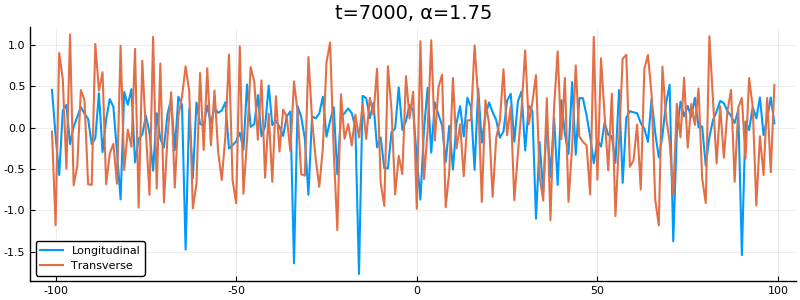

In [169]:
pyplot(size = (800,300), legend = true)


p1 = solution[2000,1].-α
p2 = solution[2000,2]
p = [p1[924:1124],p2[924:1124]]
plot(n[924:1124],p, title="t=7000, α=1.75", label=["Longitudinal" "Transverse"],lw=1.5)

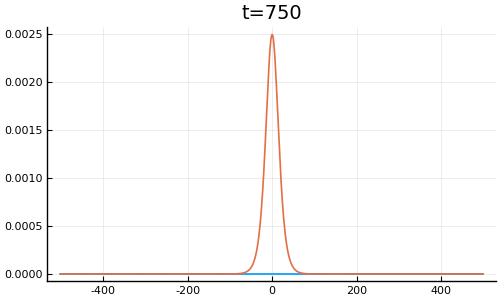

In [157]:
using Plots

pyplot(size = (500,300), legend = false)


p1 = solution[1,1].-α
p2 = solution[1,2]
p = [p1[824:1224],p2[524:1524]]
plot(n[524:1524],p,title="t=750", label=["Longitudinal" "Transverse"],lw=1.2)



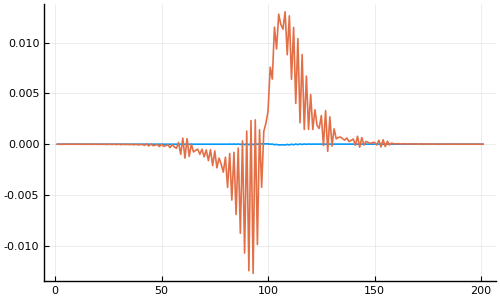

In [168]:
pyplot(size = (500,300), legend = false)


p1 = solution[700,1].-α
p2 = solution[700,2]
p = [p1[924:1124],p2[924:1124]]
plot(p, lw=1.2)


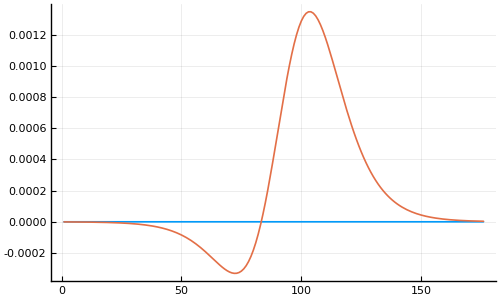

In [118]:
pyplot(size = (500,300), legend = false)


p1 = solution[70,1].-α
p2 = solution[70,2]
p = [p1[550:725],p2[550:725]]
plot(p,lw=1.2)